In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
%matplotlib inline
sns.set(style='white', rc={'figure.figsize':(12,8)})

import requests
import zipfile
import imageio

import datashader as ds
import datashader.transfer_functions as tf
import colorcet

import umap
import MulticoreTSNE
import fitsne
import LargeVis

In [2]:
%time df = pd.read_csv('GoogleNews-vectors-negative300.txt', nrows=200000, skiprows=1, header=None, sep=' ')

CPU times: user 13.7 s, sys: 1.36 s, total: 15.1 s
Wall time: 15.7 s


In [3]:
df.set_index(0, inplace=True)

In [4]:
df.head(3)

,1,2,3,4,5,6,7,8,9,10,...,291,292,293,294,295,296,297,298,299,300
0,,,,,,,,,,,,,,,,,,,,,
</s>,0.001129,-0.000896,0.000319,0.001534,0.001106,-0.001404,-0.000031,-0.000420,-0.000576,0.001076,...,-0.001549,0.001373,-0.000061,-0.000824,0.001328,0.001160,0.000568,-0.001564,-0.000123,-0.000086
in,0.070312,0.086914,0.087891,0.062500,0.069336,-0.108887,-0.081543,-0.154297,0.020752,0.131836,...,-0.168945,-0.088867,-0.080566,0.064941,0.061279,-0.047363,-0.058838,-0.047607,0.014465,-0.062500
for,-0.011780,-0.047363,0.044678,0.063477,-0.018188,-0.063965,-0.001312,-0.072266,0.064453,0.086426,...,-0.022583,0.003723,-0.082520,0.081543,0.007935,0.000477,0.018433,0.071289,-0.034912,0.024170


In [5]:
data = np.array(df.values, dtype=np.float64, order='C')

Next we pull the object id's from the file names using pandas

### Now we have our data in a list of vectors.  Let's extract the object id's from the files and cast to data frame (in case we want to explore things further)

### Now let's use UMAP to embed these points into a two dimensional space.

In [6]:
fit = umap.UMAP(random_state=42, metric='cosine', repulsion_strength=2.0)
%time u = fit.fit_transform(data)

CPU times: user 6min 39s, sys: 23.8 s, total: 7min 2s
Wall time: 6min 1s


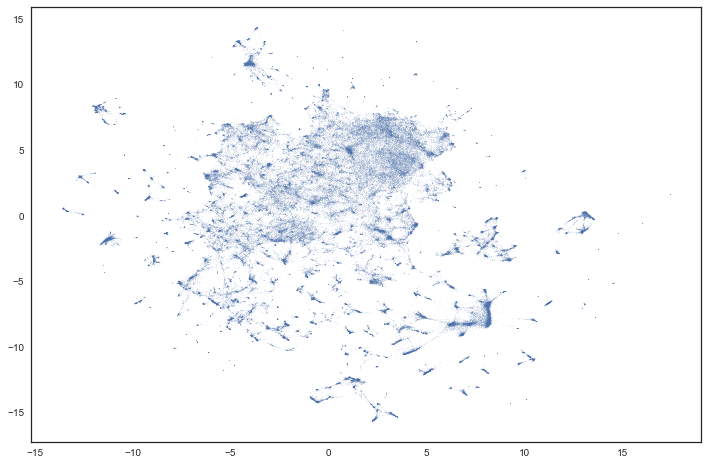

In [7]:
plt.scatter(u[:,0], u[:,1], s=0.005)

/Users/leland/anaconda3/envs/umap_dev/lib/python3.5/site-packages/datashader/transfer_functions.py:146: RuntimeWarning: invalid value encountered in log1p
  _interpolate_lookup = {'log': lambda d, m: np.log1p(np.where(m, np.nan, d)),


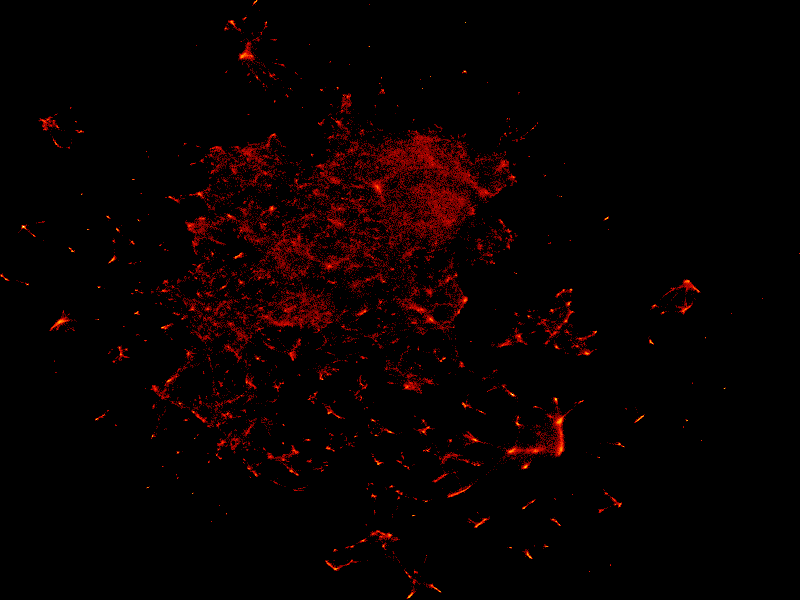

In [8]:
cvs = ds.Canvas(plot_width=800, plot_height=600)
agg = cvs.points(pd.DataFrame(u, columns=['x_col', 'y_col']), 'x_col', 'y_col')
img = tf.set_background(tf.shade(agg, cmap=colorcet.fire, how='log'),"black")
img

In [9]:
embedding = pd.DataFrame({'word':df.index, 'x':u[:,0], 'y':u[:,1]})
embedding.to_csv("embedding_word_200_umap1.csv")

## FIt-SNE

To get angulat distance we need to l2 normalize the data.

In [10]:
from sklearn.preprocessing import normalize

In [11]:
tsne_data = normalize(data, norm='l2')

In [12]:
%time u_fitsne = fitsne.FItSNE(tsne_data.astype(np.double, order='C'), nthreads=1, rand_seed=42)

CPU times: user 10min 27s, sys: 20.8 s, total: 10min 48s
Wall time: 10min 52s


In [13]:
embedding = pd.DataFrame({'word':df.index, 'x':u_fitsne[:,0], 'y':u_fitsne[:,1]})
embedding.to_csv("embedding_word_200_fitsne1.csv")

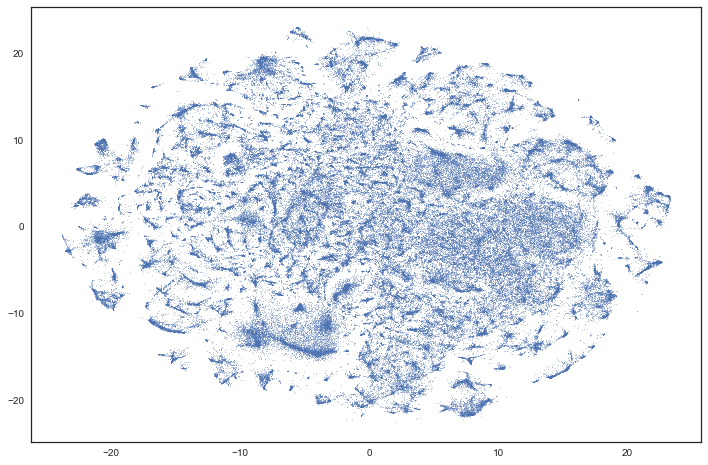

In [14]:
plt.scatter(u_fitsne[:,0], u_fitsne[:,1], s=0.1)

/Users/leland/anaconda3/envs/umap_dev/lib/python3.5/site-packages/datashader/transfer_functions.py:146: RuntimeWarning: invalid value encountered in log1p
  _interpolate_lookup = {'log': lambda d, m: np.log1p(np.where(m, np.nan, d)),


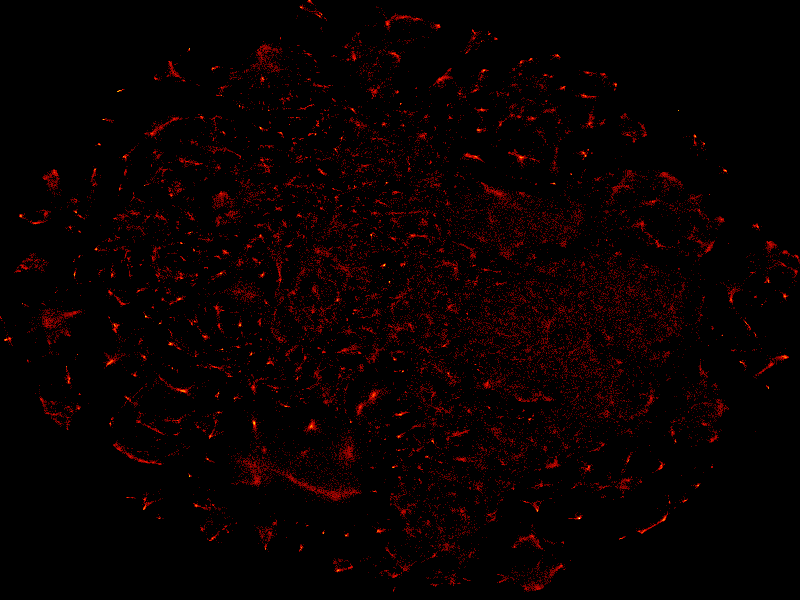

In [15]:
cvs = ds.Canvas(plot_width=800, plot_height=600)
agg = cvs.points(pd.DataFrame(u_fitsne, columns=['x_col', 'y_col']), 'x_col', 'y_col')
img = tf.set_background(tf.shade(agg, cmap=colorcet.fire, how='log'),"black")
img

# t-SNE

In [16]:
fit_tsne = MulticoreTSNE.MulticoreTSNE(n_jobs=1, random_state=42)
%time u_tsne = fit_tsne.fit_transform(tsne_data)

CPU times: user 4h 39min 53s, sys: 1min 28s, total: 4h 41min 22s
Wall time: 4h 41min 46s


In [17]:
embedding = pd.DataFrame({'word':df.index, 'x':u_tsne[:,0], 'y':u_tsne[:,1]})
embedding.to_csv("embedding_word_200_tsne1.csv")

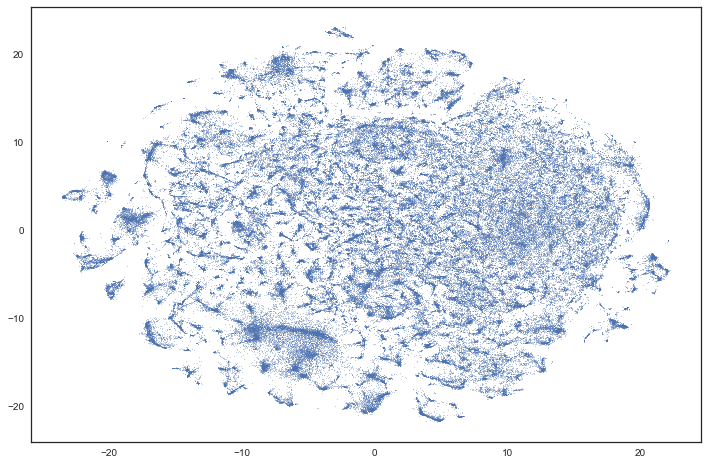

In [18]:
plt.scatter(u_tsne[:,0], u_tsne[:,1], s=0.1)

/Users/leland/anaconda3/envs/umap_dev/lib/python3.5/site-packages/datashader/transfer_functions.py:146: RuntimeWarning: invalid value encountered in log1p
  _interpolate_lookup = {'log': lambda d, m: np.log1p(np.where(m, np.nan, d)),


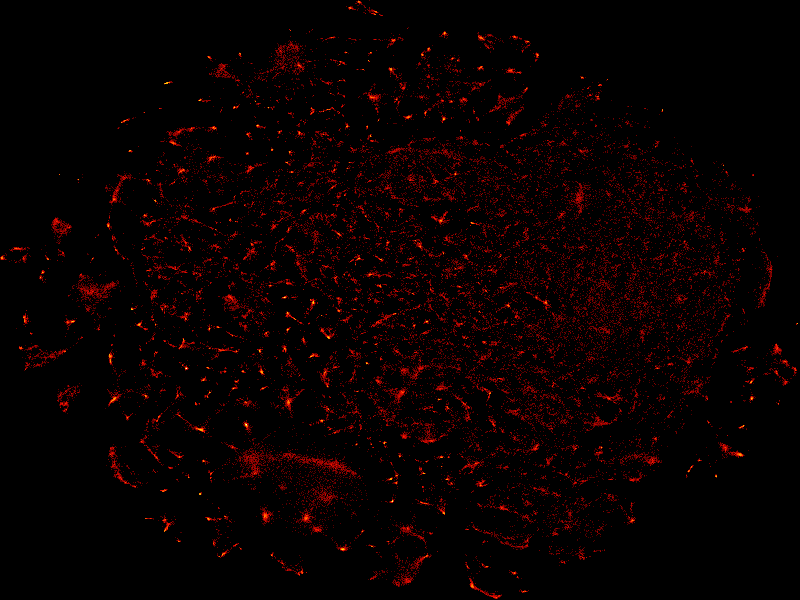

In [19]:
cvs = ds.Canvas(plot_width=800, plot_height=600)
agg = cvs.points(pd.DataFrame(u_tsne, columns=['x_col', 'y_col']), 'x_col', 'y_col')
img = tf.set_background(tf.shade(agg, cmap=colorcet.fire, how='log'),"black")
img

### PCA

The old standby of PCA which is blindingly fast to compute and often used as an initialization to many of the more complex algorithms.  This isn't really a competitor but instead should be thought of as a strawman.  Given that other algorithms initialize with these values one would hope that they can do better.

In [20]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
%time u_pca = pca.fit_transform(tsne_data)

CPU times: user 4.57 s, sys: 1.81 s, total: 6.38 s
Wall time: 4.92 s


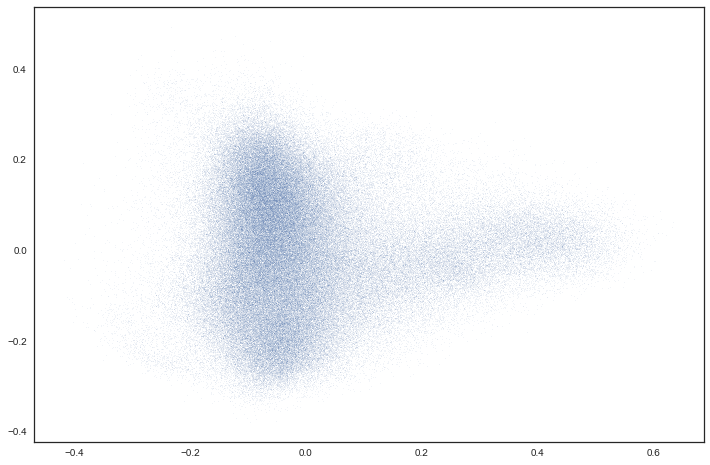

In [21]:
plt.scatter(u_pca[:,0], u_pca[:,1],  s=0.005)

/Users/leland/anaconda3/envs/umap_dev/lib/python3.5/site-packages/datashader/transfer_functions.py:146: RuntimeWarning: invalid value encountered in log1p
  _interpolate_lookup = {'log': lambda d, m: np.log1p(np.where(m, np.nan, d)),


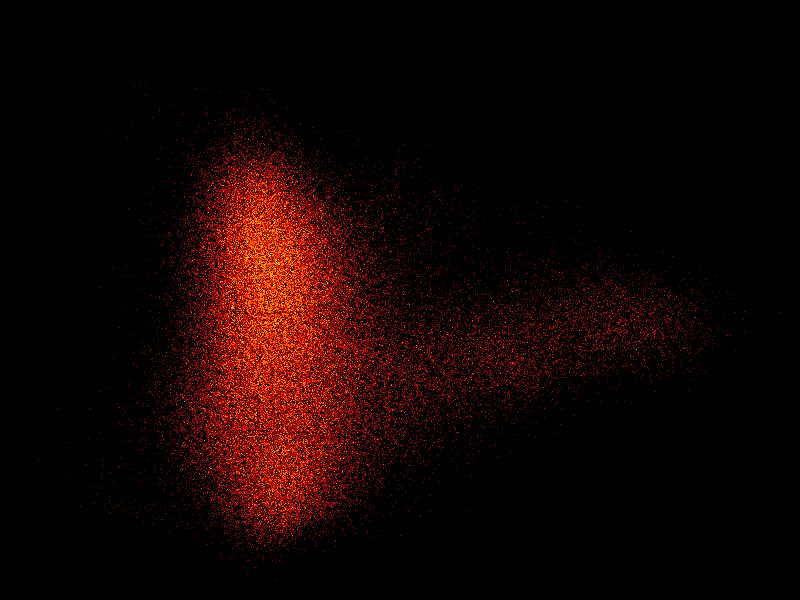

In [22]:
cvs = ds.Canvas(plot_width=800, plot_height=600)
agg = cvs.points(pd.DataFrame(u_pca, columns=['x_col', 'y_col']), 'x_col', 'y_col')
img = tf.set_background(tf.shade(agg, cmap=colorcet.fire, how='log'),"black")
img

## LargeVis

In [23]:
largevis_data = tsne_data.astype(np.float32, order='C')
LargeVis.loadarray(largevis_data)

In [24]:
%time u_largevis = LargeVis.run(2, 1)

CPU times: user 1h 28min 58s, sys: 46 s, total: 1h 29min 44s
Wall time: 1h 29min 52s


In [25]:
u_largevis = np.array(u_largevis)

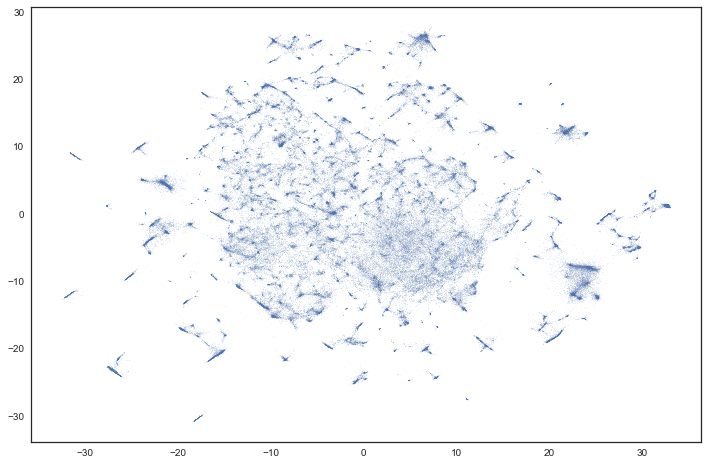

In [29]:
plt.scatter(u_largevis[:,0], u_largevis[:,1],  s=0.005)

/Users/leland/anaconda3/envs/umap_dev/lib/python3.5/site-packages/datashader/transfer_functions.py:146: RuntimeWarning: invalid value encountered in log1p
  _interpolate_lookup = {'log': lambda d, m: np.log1p(np.where(m, np.nan, d)),


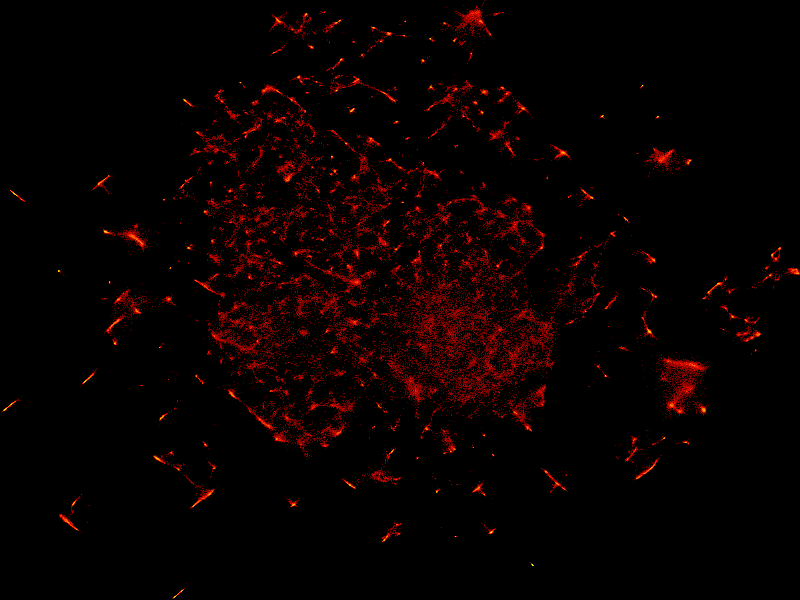

In [30]:
cvs = ds.Canvas(plot_width=800, plot_height=600)
agg = cvs.points(pd.DataFrame(u_largevis, columns=['x_col', 'y_col']), 'x_col', 'y_col')
img = tf.set_background(tf.shade(agg, cmap=colorcet.fire, how='log'),"black")
img

In [28]:
embedding = pd.DataFrame({'word':df.index, 'x':u_largevis[:,0], 'y':u_largevis[:,1]})
embedding.to_csv("embedding_word_200_largevis1.csv")